In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE


In [76]:
df=pd.read_csv

In [77]:
df= pd.read_csv('../data/sample_limpios.csv')

In [78]:
df = df[df[" Label"] != "heartbleed"]

In [79]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop(columns=[' Label'])
y = df[' Label'] 

In [80]:
print("Características (X):", X.columns.tolist())
print("\nVariable objetivo (y):", y.unique()) 

Características (X): ['Unnamed: 0.1', 'Unnamed: 0', ' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Cou

In [81]:
# distribución de clases de y
class_distribution = pd.Series(y).value_counts()
print(class_distribution)

 Label
benign                        81206
dos hulk                       7670
ddos                           5639
portscan                       3995
dos goldeneye                   430
ftp-patator                     259
dos slowloris                   259
dos slowhttptest                237
ssh-patator                     149
bot                              67
web attack � brute force         64
web attack � xss                 21
web attack � sql injection        3
Name: count, dtype: int64


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

###  Sobremuestreo (Oversampling) con SMOTE

Podemos generar más muestras sintéticas de las clases minoritarias usando SMOTE (Synthetic Minority Over-sampling Technique).

In [83]:
# Aplicar SMOTE solo en el conjunto de entrenamiento (¡Nunca en el test!)
smote = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar la nueva distribución de clases después de SMOTE
print(pd.Series(y_train_resampled).value_counts())

 Label
benign                        64965
dos hulk                      64965
portscan                      64965
ddos                          64965
bot                           64965
dos slowhttptest              64965
dos goldeneye                 64965
web attack � brute force      64965
dos slowloris                 64965
web attack � xss              64965
ftp-patator                   64965
ssh-patator                   64965
web attack � sql injection    64965
Name: count, dtype: int64


### Random Forest

In [84]:
modelo = RandomForestClassifier(
    n_estimators=50,  # Menos árboles
    max_depth=5,  # Limitar profundidad
    min_samples_leaf=5,  # Mayor número de muestras en cada hoja
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)



scores = cross_val_score(modelo, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')

print(f"Precisión de cada fold: {scores}")
print(f"Precisión media: {scores.mean()}")

modelo.fit(X_train_resampled, y_train_resampled)

Precisión de cada fold: [0.92577926 0.92094921 0.91662917]
Precisión media: 0.9211192111921119


RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [85]:
y_pred = modelo.predict(X_test)

In [86]:
assert len(y_pred) == len(y_test), "El número de predicciones y etiquetas verdaderas no coincide."

**Para modelos de clasificación, como es el caso de Random Forest, las siguientes métricas son especialmente útiles:**

- Matriz de Confusión: Proporciona una visión detallada de las          predicciones del modelo, mostrando la relación entre las clases         verdaderas y las predichas.

- Exactitud (Accuracy): Indica el porcentaje de predicciones correctas sobre el total de predicciones realizadas.

- Precisión (Precision): Mide la proporción de verdaderos positivos entre todas las instancias que fueron clasificadas como positivas.

- Sensibilidad (Recall) o Tasa de Verdaderos Positivos: Indica la proporción de verdaderos positivos que fueron correctamente identificados por el modelo.

-  Puntuación F1: Es la media armónica entre la precisión y la sensibilidad, proporcionando una medida equilibrada entre ambas.

### Matriz de Confusión, Exactitud, Precisión, Sensibilidad, Puntuación F1

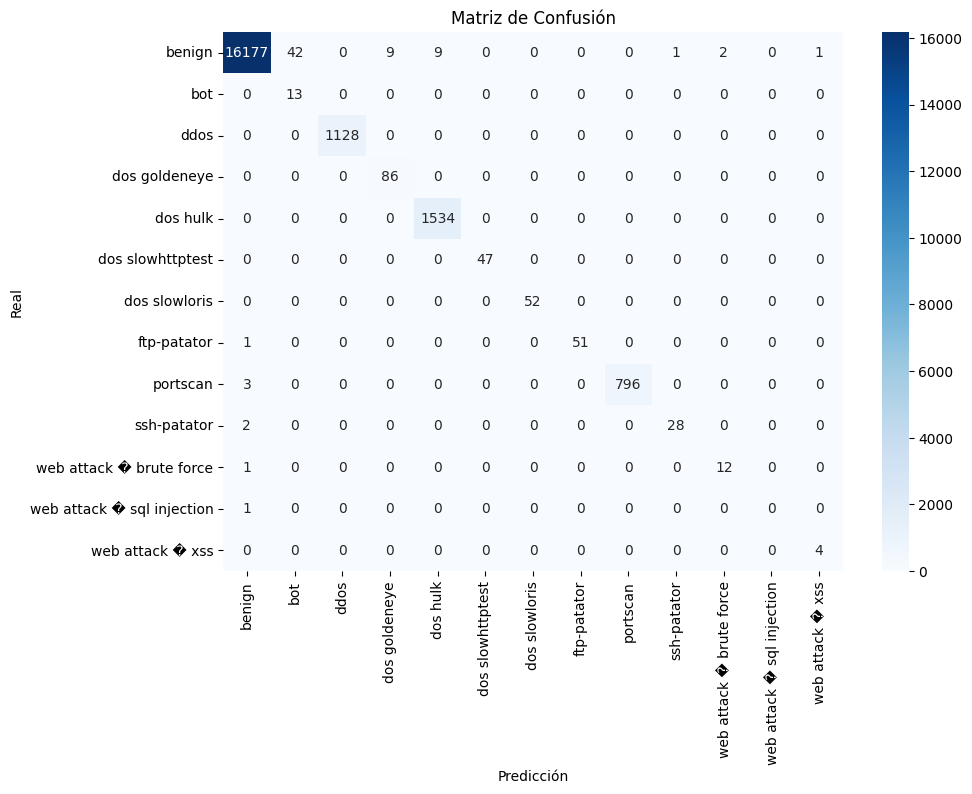

Exactitud: 0.88
Precisión: 0.98
Sensibilidad: 0.88
Puntuación F1: 0.93


In [87]:
# Matriz de Confusión
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Exactitud
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud: {accuracy:.2f}")

# Precisión
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0.0)
print(f"Precisión: {precision:.2f}")

# Sensibilidad (Recall)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Sensibilidad: {recall:.2f}")

# Puntuación F1
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Puntuación F1: {f1:.2f}")

¿Cómo interpretarla?

Por ejemplo, en la primera fila:

- La primera celda 371879 muestra cuántos casos de la clase 0 fueron correctamente clasificados como clase 0.
- La segunda celda 3 muestra cuántos casos de la clase 0 fueron incorrectamente clasificados como clase 1.
- Y así sucesivamente.

¿Qué significan los valores clave?

- Diagonal principal: Los valores de la diagonal (como 371879, 325, 25352, etc.) representan las predicciones correctas para cada clase.
- Fuera de la diagonal: Los valores fuera de la diagonal (como los 3, 18, 4, etc.) son los errores de clasificación, es decir, casos en los que el modelo ha predicho una clase equivocada.

### 📈 Curva ROC y AUC (Para Modelos Multiclase)

Si quieres ver cómo se comporta el modelo en términos de sensibilidad vs especificidad, usa la curva ROC y el AUC:

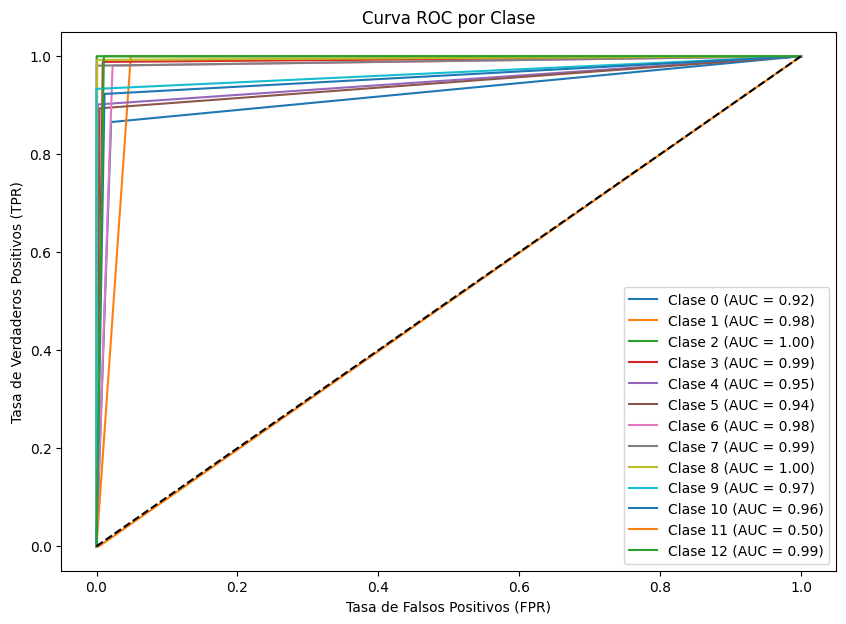

In [88]:
# Binarizar las etiquetas de y_test
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

plt.figure(figsize=(10, 7))

for i in range(y_test_bin.shape[1]): 
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC por Clase")
plt.legend()
plt.show()


- Un AUC cercano a 1 indica que la clase se predice bien.
- Si AUC está cerca de 0.5, significa que el modelo no está diferenciando bien.